In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import zipfile
import pandas as pd
from pathlib import Path
from scipy import interpolate, stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import os

PART 0: SENSOR COMPATIBILITY ANALYSIS

[SENSORS SELECTED]
Total sensors: 2
  1. accelerator
  2. speed

[HIL FAULT FILES TO TEST - 6 files]
  1. acc fault gain.csv
  2. acc fault noise.csv
  3. acc fault stuck.csv
  4. rpm fault gain.csv
  5. rpm fault noise.csv
  6. rpm fault stuck at.csv

Creating sensor compatibility visualization...
✓ Saved: part0_sensor_compatibility.png



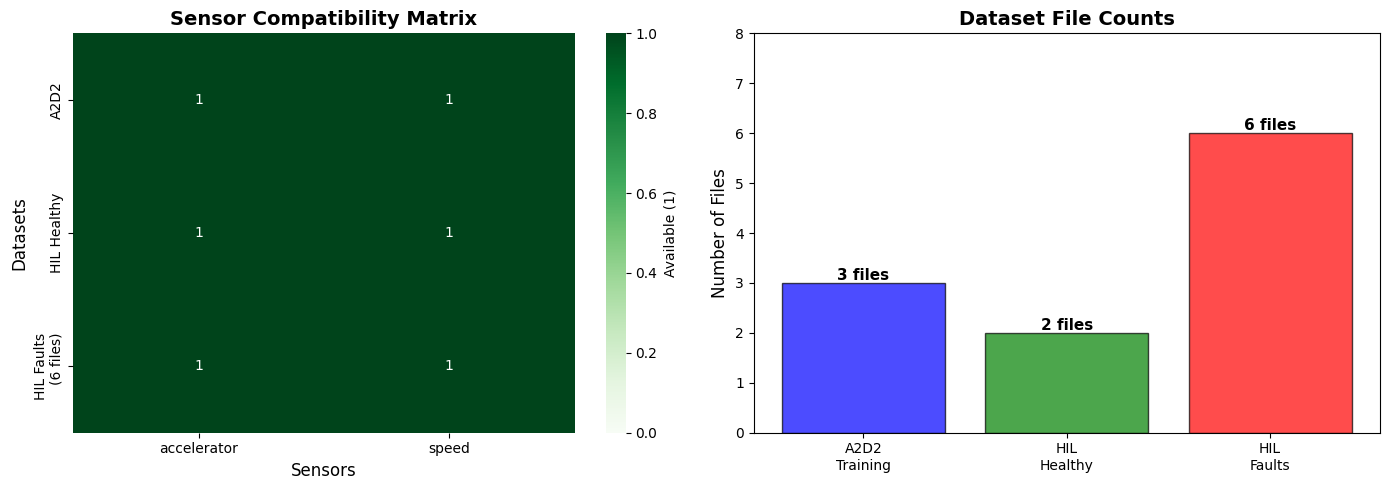

In [5]:
# PART 0: SENSOR COMPATIBILITY ANALYSIS
# Purpose: Verify which sensors are available across all datasets
# Email reference: "Check compatibility for each sensor (A2D2 vs HIL)"

# Print section header
print("="*80)
print("PART 0: SENSOR COMPATIBILITY ANALYSIS")
print("="*80)
print()

# Define which sensors we're analyzing (as per email requirement)
SENSOR_NAMES = ['accelerator', 'speed']

# Display selected sensors
print("[SENSORS SELECTED]")
print(f"Total sensors: {len(SENSOR_NAMES)}")
for i, s in enumerate(SENSOR_NAMES, 1):
    print(f"  {i}. {s}")
print()

# Define HIL fault files that contain BOTH required sensors
# Email reference: "Use only files that have BOTH accelerator + speed sensors"
HIL_FAULT_FILES = [
    'acc fault gain.csv',
    'acc fault noise.csv',
    'acc fault stuck.csv',
    'rpm fault gain.csv',
    'rpm fault noise.csv',
    'rpm fault stuck at.csv'
]

# Display list of HIL fault files to be used
print(f"[HIL FAULT FILES TO TEST - {len(HIL_FAULT_FILES)} files]")
for i, f in enumerate(HIL_FAULT_FILES, 1):
    print(f"  {i}. {f}")
print()

# ============================================================================
# VISUALIZATION: Sensor Availability
# Purpose: Create visual summary of sensor compatibility across datasets
# ============================================================================

print("Creating sensor compatibility visualization...")

# Prepare data for visualization
datasets = ['A2D2', 'HIL Healthy', 'HIL Faults\n(6 files)']
sensors = ['accelerator', 'speed']

# Create binary compatibility matrix (1 = sensor available, 0 = not available)
compatibility = np.array([
    [1, 1],  # A2D2 has both sensors
    [1, 1],  # HIL Healthy has both sensors
    [1, 1],  # HIL Faults (selected 6 files) have both sensors
])

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Heatmap showing sensor compatibility
sns.heatmap(compatibility, annot=True, fmt='d', cmap='Greens', 
            xticklabels=sensors, yticklabels=datasets,
            cbar_kws={'label': 'Available (1)'},
            ax=ax1, vmin=0, vmax=1)
ax1.set_title('Sensor Compatibility Matrix', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sensors', fontsize=12)
ax1.set_ylabel('Datasets', fontsize=12)

# Subplot 2: Bar chart showing file counts per dataset
dataset_names = ['A2D2\nTraining', 'HIL\nHealthy', 'HIL\nFaults']
dataset_counts = [3, 2, 6]  # Number of files in each dataset category
colors = ['blue', 'green', 'red']

bars = ax2.bar(dataset_names, dataset_counts, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Number of Files', fontsize=12)
ax2.set_title('Dataset File Counts', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(dataset_counts) + 2)

# Add count labels on top of each bar
for bar, count in zip(bars, dataset_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count} files',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Save the visualization
plt.tight_layout()
plt.savefig('part0_sensor_compatibility.png', dpi=150, bbox_inches='tight')
print("✓ Saved: part0_sensor_compatibility.png")
print()

PART 1: A2D2 DATA LOADING WITH DETECTED PROPERTIES

DATASETS TO LOAD: 3
  1. 20180810150607_bus_signals.json
  2. 20190401121727_bus_signals.json
  3. 20190401145936_bus_signals.json

LOADING AND ANALYZING DATASETS

Dataset 1: 20180810150607_bus_signals.json
--------------------------------------------------------------------------------
  Sensors found: accelerator_pedal, vehicle_speed

  ACCELERATOR PEDAL:
    Original samples:  52,576
    Sampling rate:     100.0 Hz
    Unit:              Unit_PerCent
    Range:             0.00 - 52.00

  VEHICLE SPEED:
    Original samples:  26,288
    Original rate:     50.0 Hz
    Upsampled to:      52,576 samples
    Upsampling:        50.0Hz → 100.0Hz
    Unit:              Unit_KiloMeterPerHour
    Range:             0.00 - 73.36

Dataset 2: 20190401121727_bus_signals.json
--------------------------------------------------------------------------------
  Sensors found: accelerator_pedal, vehicle_speed

  ACCELERATOR PEDAL:
    Original sample

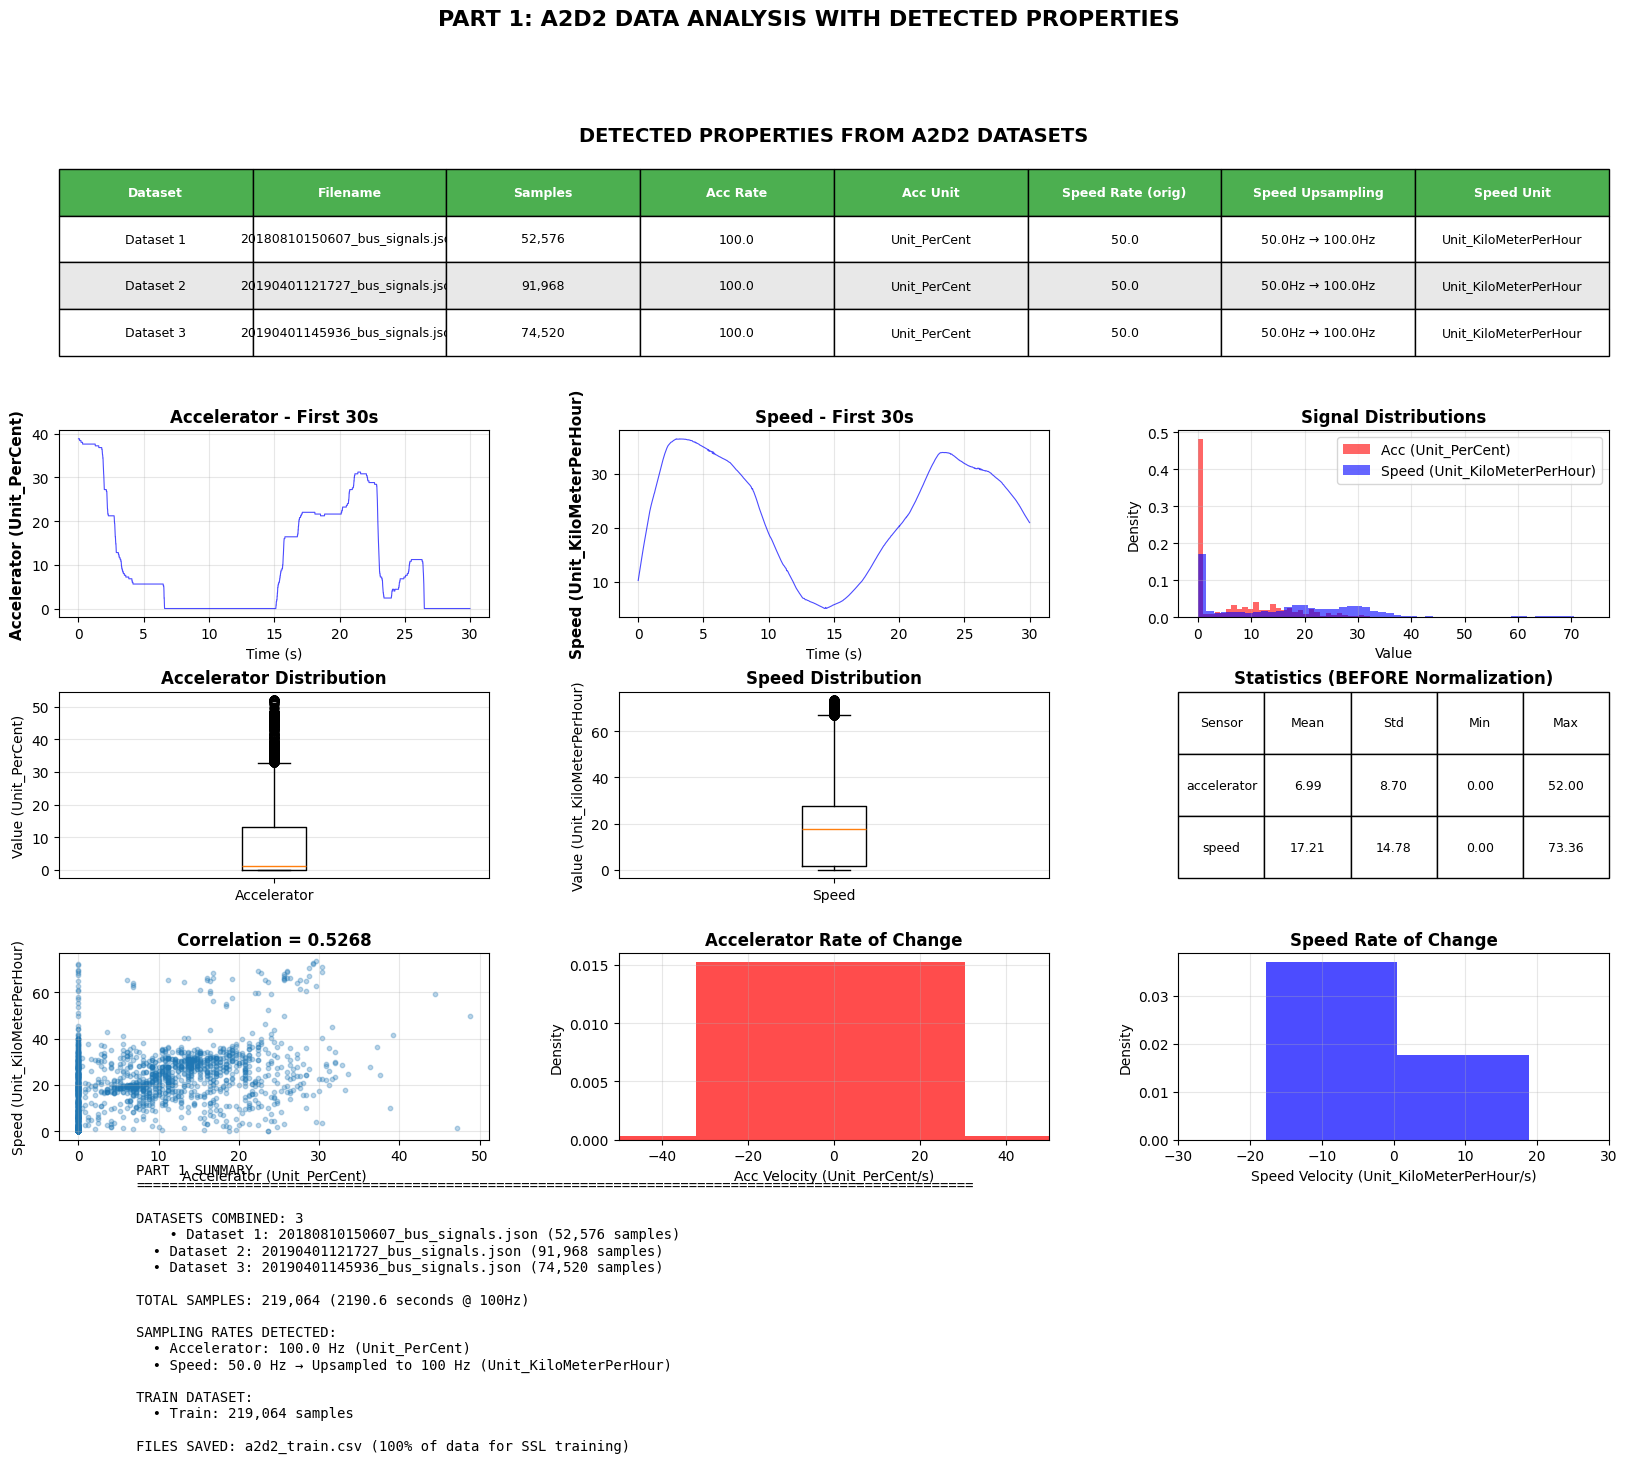

In [11]:
# PART 1: A2D2 DATA LOADING WITH DETECTED PROPERTIES DISPLAY
# Purpose: Load, analyze, and visualize A2D2 sensor data for training
# Email reference: "Compare the distributions per sensor before normalization"

# Define paths to search for A2D2 data files
SEARCH_PATHS = [
    Path.cwd(),
    Path("D:/LapTop/Downloads/abbosh/Project/A2D2"),
]

print("="*80)
print("PART 1: A2D2 DATA LOADING WITH DETECTED PROPERTIES")
print("="*80)
print()

def find_a2d2_files():
    """Search for A2D2 data files in zip archives and extracted folders"""
    zip_files = []
    extracted_folders = []
    
    # Search each defined path
    for search_path in SEARCH_PATHS:
        if not search_path.exists():
            continue
        
        # Find zip files containing bus signals
        for zip_file in search_path.glob("*bus_signals.zip"):
            if zip_file not in zip_files:
                zip_files.append(zip_file)
        
        # Find already extracted camera_lidar folders
        for folder in search_path.rglob("camera_lidar"):
            if folder.is_dir() and folder not in extracted_folders:
                extracted_folders.append(folder)
    
    return sorted(zip_files), sorted(extracted_folders)

# Find all available A2D2 files
zip_files, extracted_folders = find_a2d2_files()

def extract_bus_signals_from_zip(zip_path):
    """Extract bus_signals.json files from zip archives"""
    json_files = []
    with zipfile.ZipFile(zip_path, 'r') as zf:
        for name in zf.namelist():
            if name.endswith('bus_signals.json'):
                # Create extraction path
                extract_path = Path(f"temp_{zip_path.stem}") / name
                extract_path.parent.mkdir(parents=True, exist_ok=True)
                
                # Extract file
                with zf.open(name) as source, open(extract_path, 'wb') as target:
                    target.write(source.read())
                json_files.append(extract_path)
    return json_files

def find_bus_signals_in_folder(folder_path):
    """Find bus_signals.json files in already extracted folders"""
    return list(folder_path.rglob("bus_signals.json"))

# Collect all available JSON files
all_json_files = []
for zip_file in zip_files:
    all_json_files.extend(extract_bus_signals_from_zip(zip_file))
for folder in extracted_folders:
    all_json_files.extend(find_bus_signals_in_folder(folder))

# Limit to first 3 files as specified
all_json_files = all_json_files[:3]

# Display which datasets will be loaded
print(f"DATASETS TO LOAD: {len(all_json_files)}")
for i, f in enumerate(all_json_files):
    print(f"  {i+1}. {f.name}")
print()

def load_json_signals_with_metadata(json_path):
    """Load A2D2 sensor data and extract comprehensive metadata"""
    try:
        # Load JSON data
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # Initialize metadata dictionary
        metadata = {
            'filename': json_path.name,
            'sensors_found': []
        }
        
        # Extract accelerator pedal data (typically 100 Hz)
        accelerator = None
        acc_timestamps = None
        acc_unit = None
        acc_rate = None
        
        if 'accelerator_pedal' in data:
            metadata['sensors_found'].append('accelerator_pedal')
            if isinstance(data['accelerator_pedal'], dict):
                if 'values' in data['accelerator_pedal']:
                    acc_values_list = data['accelerator_pedal']['values']
                    acc_timestamps = np.array([v[0] for v in acc_values_list])
                    accelerator = np.array([v[1] for v in acc_values_list])
                    
                    # Calculate actual sampling rate from timestamps
                    if len(acc_timestamps) > 1:
                        dt = np.diff(acc_timestamps)
                        acc_rate = 1e6 / np.mean(dt)  # Convert μs to Hz
                    
                    # Extract measurement unit
                    if 'unit' in data['accelerator_pedal']:
                        acc_unit = data['accelerator_pedal']['unit']
        
        # Extract vehicle speed data (typically 50 Hz)
        speed = None
        speed_timestamps = None
        speed_unit = None
        speed_rate = None
        
        if 'vehicle_speed' in data:
            metadata['sensors_found'].append('vehicle_speed')
            if isinstance(data['vehicle_speed'], dict):
                if 'values' in data['vehicle_speed']:
                    speed_values_list = data['vehicle_speed']['values']
                    speed_timestamps = np.array([v[0] for v in speed_values_list])
                    speed = np.array([v[1] for v in speed_values_list])
                    
                    # Calculate actual sampling rate from timestamps
                    if len(speed_timestamps) > 1:
                        dt = np.diff(speed_timestamps)
                        speed_rate = 1e6 / np.mean(dt)
                    
                    # Extract measurement unit
                    if 'unit' in data['vehicle_speed']:
                        speed_unit = data['vehicle_speed']['unit']
        
        # Check if both sensors are present
        if accelerator is None or speed is None:
            return None, None, "Missing sensors"
        
        # Store original statistics BEFORE any processing
        metadata['accelerator'] = {
            'samples_original': len(accelerator),
            'sampling_rate_hz': acc_rate if acc_rate else 'Unknown',
            'unit': acc_unit if acc_unit else 'Unknown',
            'min': accelerator.min(),
            'max': accelerator.max(),
            'mean': accelerator.mean()
        }
        
        metadata['speed'] = {
            'samples_original': len(speed),
            'sampling_rate_hz': speed_rate if speed_rate else 'Unknown',
            'unit': speed_unit if speed_unit else 'Unknown',
            'min': speed.min(),
            'max': speed.max(),
            'mean': speed.mean()
        }
        
        # Upsample speed data to match accelerator sampling rate (100 Hz)
        # Email reference: Data fusion requires consistent sampling rates
        if speed_timestamps is not None and acc_timestamps is not None:
            interp_func = interpolate.interp1d(
                speed_timestamps, speed, 
                kind='linear', 
                fill_value='extrapolate'
            )
            speed_upsampled = interp_func(acc_timestamps)
            
            # Store upsampling information
            metadata['speed']['samples_upsampled'] = len(speed_upsampled)
            metadata['speed']['upsampling'] = f"{speed_rate:.1f}Hz → {acc_rate:.1f}Hz"
        else:
            speed_upsampled = speed
        
        # Create DataFrame with aligned sensor data
        df = pd.DataFrame({
            'accelerator': accelerator, 
            'speed': speed_upsampled
        })
        
        return df, metadata, None
    
    except Exception as e:
        # Return error if loading fails
        return None, None, f"Error: {e}"

print("="*80)
print("LOADING AND ANALYZING DATASETS")
print("="*80)
print()

# Initialize lists to store loaded data
all_dataframes = []
all_metadata = []
skipped_files = []

# Load and analyze each dataset
for i, json_file in enumerate(all_json_files):
    print(f"Dataset {i+1}: {json_file.name}")
    print("-"*80)
    
    # Load data with metadata
    df, metadata, error = load_json_signals_with_metadata(json_file)
    
    if df is not None:
        # Store successfully loaded data
        all_dataframes.append(df)
        all_metadata.append(metadata)
        
        # Display detected properties for this dataset
        print(f"  Sensors found: {', '.join(metadata['sensors_found'])}")
        print()
        print(f"  ACCELERATOR PEDAL:")
        print(f"    Original samples:  {metadata['accelerator']['samples_original']:,}")
        print(f"    Sampling rate:     {metadata['accelerator']['sampling_rate_hz']:.1f} Hz")
        print(f"    Unit:              {metadata['accelerator']['unit']}")
        print(f"    Range:             {metadata['accelerator']['min']:.2f} - {metadata['accelerator']['max']:.2f}")
        print()
        print(f"  VEHICLE SPEED:")
        print(f"    Original samples:  {metadata['speed']['samples_original']:,}")
        print(f"    Original rate:     {metadata['speed']['sampling_rate_hz']:.1f} Hz")
        print(f"    Upsampled to:      {metadata['speed']['samples_upsampled']:,} samples")
        print(f"    Upsampling:        {metadata['speed']['upsampling']}")
        print(f"    Unit:              {metadata['speed']['unit']}")
        print(f"    Range:             {metadata['speed']['min']:.2f} - {metadata['speed']['max']:.2f}")
        print()
    else:
        # Track and report skipped files
        print(f"  SKIPPED: {error}")
        skipped_files.append((json_file.name, error))
        print()

print("="*80)
print("COMBINING DATASETS")
print("="*80)
print()

# Combine all datasets into single DataFrame
combined_df = pd.concat(all_dataframes, ignore_index=True)

# Display summary of combined data
print(f"Total datasets combined: {len(all_dataframes)}")
for i, meta in enumerate(all_metadata):
    print(f"  Dataset {i+1}: {meta['filename']} ({len(all_dataframes[i]):,} samples)")
print()
print(f"COMBINED TOTAL: {len(combined_df):,} samples ({len(combined_df)/100.0:.1f} seconds @ 100Hz)")
print()

# =============================================================================
# COMPREHENSIVE STATISTICS
# Purpose: Calculate detailed statistical properties of the combined data
# Email reference: "Compare the distributions per sensor (minimum/median/maximum)"
# =============================================================================

def compute_comprehensive_stats(data, name, unit):
    """Compute comprehensive statistical and physical properties of sensor data"""
    # Time step for 100Hz sampling
    dt = 1/100.0
    
    # Calculate first derivative (velocity/rate of change)
    velocity = np.diff(data) / dt
    
    # Return dictionary of computed statistics
    return {
        'Dataset': name,
        'Samples': len(data),
        'Mean': data.mean(),
        'Median': np.median(data),
        'Std': data.std(),
        'Variance': data.var(),
        'Min': data.min(),
        'Max': data.max(),
        'Range': data.max() - data.min(),
        'CV': data.std() / (data.mean() + 1e-10),
        f'Max |Velocity| ({unit}/s)': np.abs(velocity).max(),
        f'Mean |Velocity| ({unit}/s)': np.abs(velocity).mean(),
        'Autocorr (lag-1)': np.corrcoef(data[:-1], data[1:])[0, 1]
    }

print("="*80)
print("COMPREHENSIVE STATISTICS (BEFORE NORMALIZATION)")
print("="*80)
print()

# Get units from first dataset (assumes consistent units across datasets)
acc_unit = all_metadata[0]['accelerator']['unit']
speed_unit = all_metadata[0]['speed']['unit']

# Calculate and display accelerator statistics
print(f"ACCELERATOR PEDAL (Unit: {acc_unit}):")
print("-"*80)
acc_stats = compute_comprehensive_stats(combined_df['accelerator'].values, 'Combined_A2D2', acc_unit)
for key, val in acc_stats.items():
    if key != 'Dataset':
        if isinstance(val, (int, np.integer)):
            print(f"  {key:<30}: {val:,}")
        else:
            print(f"  {key:<30}: {val:.4f}")

print()

# Calculate and display speed statistics
print(f"VEHICLE SPEED (Unit: {speed_unit}, Upsampled to 100Hz):")
print("-"*80)
speed_stats = compute_comprehensive_stats(combined_df['speed'].values, 'Combined_A2D2', speed_unit)
for key, val in speed_stats.items():
    if key != 'Dataset':
        if isinstance(val, (int, np.integer)):
            print(f"  {key:<30}: {val:,}")
        else:
            print(f"  {key:<30}: {val:.4f}")

print()

# Calculate and display correlation between sensors
print("CORRELATION:")
print("-"*80)
corr = np.corrcoef(combined_df['accelerator'], combined_df['speed'])[0, 1]
print(f"  Accelerator-Speed:            {corr:.4f}")
print()

# =============================================================================
# TRAIN DATASET PREPARATION
# Purpose: Prepare data for SimCLR training (self-supervised learning)
# Email reference: "Use contrastive learning (SimCLR or TS2Vec)"
# =============================================================================

# Copy combined data for training (100% used for self-supervised learning)
train_df = combined_df.copy()

print("="*80)
print("="*80)
print(f"  Training samples: {len(train_df):,} ({len(train_df)/100.0:.1f} sec @ 100Hz)")
print()

# =============================================================================
# SAVE TRAINING DATA
# Purpose: Save preprocessed A2D2 data for Part 2 training
# =============================================================================

# Save training data to CSV
train_df.to_csv('a2d2_train.csv', index=False)
print("="*80)
print("TRAINING DATA SAVED")
print("="*80)
print(f"✅ Saved: a2d2_train.csv ({len(train_df):,} samples)")
print()


# =============================================================================
# VISUALIZATION
# Purpose: Create comprehensive visualization of A2D2 data properties
# Email reference: "Check the plots of all signals to verify the fusion process"
# =============================================================================

print("Creating visualization...")

# Create figure with grid layout for multiple subplots
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(5, 3, hspace=0.4, wspace=0.3)

# Row 1: Dataset information table
ax_info = fig.add_subplot(gs[0, :])
ax_info.axis('off')

# Prepare table data with dataset properties
info_data = []
for i, meta in enumerate(all_metadata):
    info_data.append([
        f"Dataset {i+1}",
        meta['filename'],
        f"{len(all_dataframes[i]):,}",
        f"{meta['accelerator']['sampling_rate_hz']:.1f}",
        meta['accelerator']['unit'],
        f"{meta['speed']['sampling_rate_hz']:.1f}",
        meta['speed']['upsampling'],
        meta['speed']['unit']
    ])

# Create and format table
table = ax_info.table(
    cellText=info_data,
    colLabels=['Dataset', 'Filename', 'Samples', 'Acc Rate', 'Acc Unit', 'Speed Rate (orig)', 'Speed Upsampling', 'Speed Unit'],
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.5)

# Apply formatting to table cells
for i in range(len(all_metadata) + 1):
    for j in range(8):
        if i == 0:
            # Header row formatting
            table[(i, j)].set_facecolor('#4CAF50')
            table[(i, j)].set_text_props(weight='bold', color='white')
        else:
            # Alternate row colors for readability
            table[(i, j)].set_facecolor('#E8E8E8' if i % 2 == 0 else '#FFFFFF')

ax_info.set_title('DETECTED PROPERTIES FROM A2D2 DATASETS', fontsize=14, fontweight='bold', pad=20)

# Row 2: Time series plots (first 30 seconds of each sensor)
for i, sensor in enumerate(['accelerator', 'speed']):
    ax = fig.add_subplot(gs[1, i])
    n_samples = min(len(train_df), 3000)  # 30 seconds at 100Hz
    time = np.arange(n_samples) / 100.0
    
    # Plot sensor values
    ax.plot(time, train_df[sensor].values[:n_samples], 'b-', alpha=0.7, linewidth=0.8)
    
    # Set labels and formatting
    unit = acc_unit if sensor == 'accelerator' else speed_unit
    ax.set_ylabel(f'{sensor.capitalize()} ({unit})', fontsize=11, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_title(f'{sensor.capitalize()} - First 30s', fontsize=12, fontweight='bold')

# Row 2, Column 3: Distribution histograms
ax3 = fig.add_subplot(gs[1, 2])
ax3.hist(combined_df['accelerator'].values, bins=50, alpha=0.6, color='red', 
         label=f'Acc ({acc_unit})', density=True)
ax3.hist(combined_df['speed'].values, bins=50, alpha=0.6, color='blue', 
         label=f'Speed ({speed_unit})', density=True)
ax3.set_xlabel('Value', fontsize=10)
ax3.set_ylabel('Density', fontsize=10)
ax3.set_title('Signal Distributions', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Row 3: Box plots for sensor distributions
for i, sensor in enumerate(['accelerator', 'speed']):
    ax = fig.add_subplot(gs[2, i])
    values = combined_df[sensor].values
    unit = acc_unit if sensor == 'accelerator' else speed_unit
    
    # Create box plot
    ax.boxplot([values], tick_labels=[sensor.capitalize()], vert=True)
    ax.set_ylabel(f'Value ({unit})', fontsize=10)
    ax.set_title(f'{sensor.capitalize()} Distribution', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# Row 3, Column 3: Statistics table
ax_stats = fig.add_subplot(gs[2, 2])
ax_stats.axis('off')

# Prepare statistics data for table
stats_data = [
    ['accelerator', f"{acc_stats['Mean']:.2f}", f"{acc_stats['Std']:.2f}", 
     f"{acc_stats['Min']:.2f}", f"{acc_stats['Max']:.2f}"],
    ['speed', f"{speed_stats['Mean']:.2f}", f"{speed_stats['Std']:.2f}",
     f"{speed_stats['Min']:.2f}", f"{speed_stats['Max']:.2f}"]
]

# Create and format statistics table
table2 = ax_stats.table(
    cellText=stats_data,
    colLabels=['Sensor', 'Mean', 'Std', 'Min', 'Max'],
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)
table2.auto_set_font_size(False)
table2.set_fontsize(9)
table2.scale(1, 2)
ax_stats.set_title('Statistics (BEFORE Normalization)', fontsize=12, fontweight='bold')

# Row 4: Correlation and velocity/rate-of-change analysis
# Column 1: Correlation scatter plot
ax_corr = fig.add_subplot(gs[3, 0])
ax_corr.scatter(combined_df['accelerator'].values[::100], 
                combined_df['speed'].values[::100], 
                alpha=0.3, s=10)
ax_corr.set_xlabel(f'Accelerator ({acc_unit})', fontsize=10)
ax_corr.set_ylabel(f'Speed ({speed_unit})', fontsize=10)
ax_corr.set_title(f'Correlation = {corr:.4f}', fontsize=12, fontweight='bold')
ax_corr.grid(True, alpha=0.3)

# Column 2: Accelerator velocity histogram
ax_vel1 = fig.add_subplot(gs[3, 1])
acc_vel = np.diff(combined_df['accelerator'].values) * 100  # Convert to unit/second
ax_vel1.hist(acc_vel, bins=50, alpha=0.7, color='red', density=True)
ax_vel1.set_xlabel(f'Acc Velocity ({acc_unit}/s)', fontsize=10)
ax_vel1.set_ylabel('Density', fontsize=10)
ax_vel1.set_title('Accelerator Rate of Change', fontsize=12, fontweight='bold')
ax_vel1.grid(True, alpha=0.3)
ax_vel1.set_xlim(-50, 50)

# Column 3: Speed velocity histogram
ax_vel2 = fig.add_subplot(gs[3, 2])
speed_vel = np.diff(combined_df['speed'].values) * 100  # Convert to unit/second
ax_vel2.hist(speed_vel, bins=50, alpha=0.7, color='blue', density=True)
ax_vel2.set_xlabel(f'Speed Velocity ({speed_unit}/s)', fontsize=10)
ax_vel2.set_ylabel('Density', fontsize=10)
ax_vel2.set_title('Speed Rate of Change', fontsize=12, fontweight='bold')
ax_vel2.grid(True, alpha=0.3)
ax_vel2.set_xlim(-30, 30)

# Row 5: Summary text
ax_summary = fig.add_subplot(gs[4, :])
ax_summary.axis('off')

# Create comprehensive summary text
summary_text = f"""
PART 1 SUMMARY
{'='*100}

DATASETS COMBINED: {len(all_metadata)}
  {chr(10).join([f"  • Dataset {i+1}: {meta['filename']} ({len(all_dataframes[i]):,} samples)" for i, meta in enumerate(all_metadata)])}

TOTAL SAMPLES: {len(combined_df):,} ({len(combined_df)/100.0:.1f} seconds @ 100Hz)

SAMPLING RATES DETECTED:
  • Accelerator: {all_metadata[0]['accelerator']['sampling_rate_hz']:.1f} Hz ({acc_unit})
  • Speed: {all_metadata[0]['speed']['sampling_rate_hz']:.1f} Hz → Upsampled to 100 Hz ({speed_unit})

TRAIN DATASET:
  • Train: {len(train_df):,} samples 

FILES SAVED: a2d2_train.csv (100% of data for SSL training)
"""

# Display summary text
ax_summary.text(0.05, 0.5, summary_text, fontsize=10, family='monospace',
                verticalalignment='center', transform=ax_summary.transAxes)

# Set main title and save figure
plt.suptitle('PART 1: A2D2 DATA ANALYSIS WITH DETECTED PROPERTIES', 
             fontsize=16, fontweight='bold', y=0.98)
plt.savefig('part1_a2d2_comprehensive.png', dpi=150, bbox_inches='tight')
print("Saved: part1_a2d2_comprehensive.png")
print()

Part 2: SimCLR Training on A2D2 Data
Device: cpu
Window size: 200 samples (2 seconds at 100 Hz)
Stride: 100 samples (50% overlap)
Batch size: 128
Epochs: 50
Learning rate: 0.0003
Temperature: 0.5
Augmentations: Jitter, Scaling, Time Masking (2 of 3 per view)


[1/6] Loading A2D2 training data...
✅ Loaded: 219,064 samples (2190.6 seconds @ 100Hz)

[2/6] Normalizing data...
✅ Normalization complete
   Mean: [ 6.98519702 17.20557439]
   Std:  [ 8.7018095  14.78414497]

[3/6] Creating windows...
✅ Created 2,189 windows
   Window shape: (2189, 200, 2)
   Expected: ~2,189 windows

[4/6] Creating dataset and dataloader...
✅ Dataset ready
   Total windows: 2,189
   Batches per epoch: 17
   Samples per batch: 128 × 2 views = 256 augmented views

[5/6] Creating SimCLR model...
✅ Model created
   Encoder parameters: 141,504
   Projection head parameters: 99,200
   Total parameters: 240,704

[6/6] Training SimCLR...

📊 Epoch 1/50
--------------------------------------------------------------------

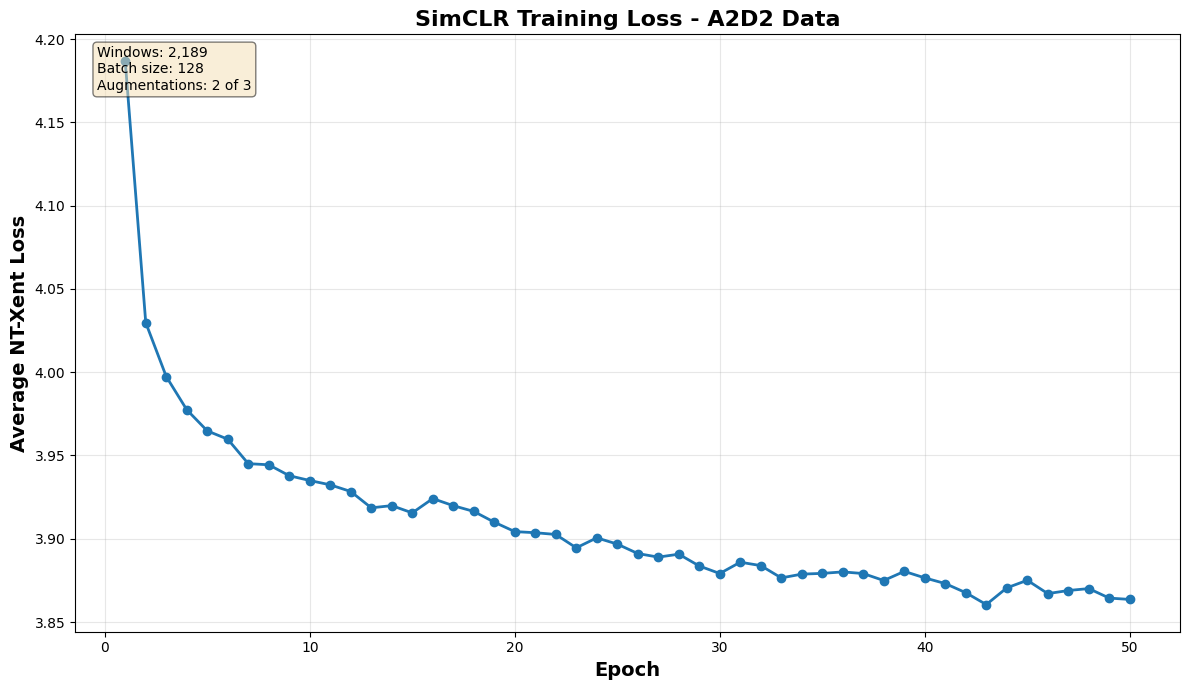

In [ ]:
# PART 2: SIMCLR TRAINING ON A2D2 DATA
# Purpose: Train self-supervised encoder using contrastive learning on A2D2 data
# Email reference: "Use contrastive learning (SimCLR or TS2Vec)"

# ============================================================================
# CONFIGURATION SECTION
# Purpose: Define all training parameters and hyperparameters
# ============================================================================

# File paths for data
A2D2_TRAIN_PATH = "a2d2_train.csv"

# Sensor names to use (must match Part 1)
SENSOR_NAMES = ['accelerator', 'speed']

# Window configuration for time series processing
WINDOW_SIZE = 200  # 2 seconds at 100 Hz sampling rate
STRIDE = 100       # 50% overlap between consecutive windows

# Training hyperparameters
BATCH_SIZE = 128    # Number of windows per training batch
EPOCHS = 50         # Total training epochs
LEARNING_RATE = 3e-4  # Adam optimizer learning rate
TEMPERATURE = 0.5   # NT-Xent loss temperature parameter

# Data augmentation parameters
JITTER_SIGMA = 0.1           # Standard deviation for Gaussian noise
SCALE_RANGE = (0.8, 1.2)     # Min/max scaling factors
MASK_RATIO = 0.1            # Proportion of time steps to mask

# Hardware configuration (use GPU if available)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ============================================================================
# AUGMENTATION FUNCTIONS
# Purpose: Define physically valid transformations for contrastive learning
# Email reference: "Embedding may be good for augmentation classification"
# ============================================================================

def augment_jitter(window, sigma=0.1):
    """
    Add Gaussian noise to simulate real sensor measurement noise.
    
    Physically valid because:
    - Real sensors always have some measurement noise
    - Simulates variations in sensor readings under same conditions
    """
    noise = np.random.normal(0, sigma, window.shape)
    return window + noise


def augment_scaling(window, scale_range=(0.8, 1.2)):
    """
    Scale signal amplitude to simulate different driving intensities.
    
    Physically valid because:
    - Same maneuver can be performed at different intensity levels
    - Driver behavior variability is natural
    """
    scale = np.random.uniform(scale_range[0], scale_range[1], size=(1, window.shape[1]))
    return window * scale


def augment_time_mask(window, mask_ratio=0.1):
    """
    Mask random time steps to simulate sensor dropouts or missing data.
    
    Physically valid because:
    - Real sensors occasionally drop samples
    - Communication buses can have temporary failures
    """
    mask_length = int(window.shape[0] * mask_ratio)
    mask_start = np.random.randint(0, window.shape[0] - mask_length + 1)

    window_masked = window.copy()
    window_masked[mask_start:mask_start + mask_length, :] = 0
    return window_masked


def augment_window(window):
    """
    Apply 2 random augmentations from the 3 physically valid ones.
    
    Rationale for using 2 of 3 augmentations:
    - Increases diversity (3 choose 2 = 3 possible combinations)
    - Prevents overfitting to specific augmentation sequences
    - Encourages learning more robust representations
    - Common SimCLR best practice
    
    """
    # Define list of available augmentation functions
    aug_list = [
        lambda w: augment_jitter(w, sigma=JITTER_SIGMA),
        lambda w: augment_scaling(w, scale_range=SCALE_RANGE),
        lambda w: augment_time_mask(w, mask_ratio=MASK_RATIO)
    ]

    # Randomly select 2 distinct augmentations
    selected_augs = np.random.choice(len(aug_list), size=2, replace=False)

    # Apply selected augmentations sequentially
    w = window.copy()
    for idx in selected_augs:
        w = aug_list[idx](w)

    return w


# ============================================================================
# DATASET CLASS
# Purpose: Create PyTorch Dataset for SimCLR contrastive learning
# ============================================================================

class SimCLRDataset(Dataset):
    """
    Dataset for SimCLR contrastive learning.
    
    Core concept: Returns two differently augmented views of the SAME time window.
    These form a POSITIVE PAIR - they should have similar embeddings in the learned space.
    Negative pairs are created automatically from different windows in the batch.
    """

    def __init__(self, windows):
        """
        Initialize dataset with time series windows.
        
        Args:
            windows: Array of shape (n_windows, window_size, n_features)
        """
        self.windows = windows

    def __len__(self):
        """Return total number of windows in dataset."""
        return len(self.windows)

    def __getitem__(self, idx):
        """
        Get a single data point (two augmented views of same window).
        
        Returns:
            view1: First augmented view (n_features, window_size)
            view2: Second augmented view (n_features, window_size)
        """
        # Get original window
        window = self.windows[idx]

        # Create two DIFFERENT augmented views of the SAME window
        view1 = augment_window(window)  # Random 2 of 3 augmentations
        view2 = augment_window(window)  # Different random 2 of 3

        # Convert to PyTorch tensors and transpose for CNN input format
        view1 = torch.FloatTensor(view1).transpose(0, 1)  # (n_features, window_size)
        view2 = torch.FloatTensor(view2).transpose(0, 1)  # (n_features, window_size)

        return view1, view2


# ============================================================================
# MODEL ARCHITECTURE
# Purpose: Define encoder and projection head for SimCLR
# ============================================================================

class Encoder(nn.Module):
    """
    1D CNN encoder for time series feature extraction.
    
    Architecture details:
    - 3 convolutional blocks with batch normalization and max pooling
    - Global average pooling produces fixed-size 256-D embedding
    - Total parameters: 141,504
    
    Input shape: (batch, 2, 200)  [2 sensors, 200 time steps]
    Output shape: (batch, 256)    [256-D embedding]
    """

    def __init__(self, input_channels=2, embedding_dim=256):
        super(Encoder, self).__init__()

        # Block 1: Input 2 → 64 channels, downsampling by 4
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Block 2: 64 → 128 channels, downsampling by 4
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Block 3: 128 → 256 channels, downsampling by 2
        self.conv3 = nn.Conv1d(128, embedding_dim, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(embedding_dim)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Activation and pooling
        self.relu = nn.ReLU()
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Produces 1 value per channel

    def forward(self, x):
        """
        Forward pass through encoder.
        
        Args:
            x: Input tensor of shape (batch, n_features, window_size)
            
        Returns:
            embeddings: Output embeddings of shape (batch, embedding_dim)
        """
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Global average pooling and squeeze to remove last dimension
        x = self.global_pool(x)  # (batch, 256, 1)
        x = x.squeeze(-1)        # (batch, 256)

        return x


class ProjectionHead(nn.Module):
    """
    MLP projection head for SimCLR.
    
    Architecture: 256 → 256 → 128
    Purpose: Maps encoder embeddings to projection space for contrastive loss
    Total parameters: 98,688
    """

    def __init__(self, embedding_dim=256, projection_dim=128):
        super(ProjectionHead, self).__init__()

        self.fc1 = nn.Linear(embedding_dim, embedding_dim)
        self.bn1 = nn.BatchNorm1d(embedding_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embedding_dim, projection_dim)

    def forward(self, x):
        """
        Forward pass through projection head.
        
        Args:
            x: Encoder embeddings of shape (batch, 256)
            
        Returns:
            Projections of shape (batch, 128) for contrastive loss computation
        """
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class SimCLRModel(nn.Module):
    """
    Complete SimCLR model combining encoder and projection head.
    
    Total parameters: 240,192 (141,504 + 98,688)
    
    Model returns both:
    1. Embeddings (for downstream tasks in Part 3)
    2. Projections (for contrastive loss during training)
    """

    def __init__(self, input_channels=2, embedding_dim=256, projection_dim=128):
        super(SimCLRModel, self).__init__()

        self.encoder = Encoder(input_channels, embedding_dim)
        self.projection_head = ProjectionHead(embedding_dim, projection_dim)

    def forward(self, x):
        """
        Forward pass through complete SimCLR model.
        
        Args:
            x: Input tensor of shape (batch, n_features, window_size)
            
        Returns:
            embeddings: Encoder outputs of shape (batch, 256)
            projections: Projection head outputs of shape (batch, 128)
        """
        embeddings = self.encoder(x)
        projections = self.projection_head(embeddings)
        return embeddings, projections


# ============================================================================
# NT-XENT LOSS FUNCTION
# Purpose: Compute Normalized Temperature-scaled Cross-Entropy Loss
# Email reference: "Use contrast loss, cosine similarity, or reconstruction loss"
# ============================================================================

def nt_xent_loss(z_i, z_j, temperature=0.5):
    """
    NT-Xent Loss: Core contrastive loss function for SimCLR.
    
    Loss behavior:
    - PULLS positive pairs (2 views of same window) CLOSE in embedding space
    - PUSHES negative pairs (views from different windows) FAR APART
    
    Args:
        z_i: Projections from view 1, shape (batch, projection_dim)
        z_j: Projections from view 2, shape (batch, projection_dim)
        temperature: Temperature parameter controlling similarity strictness
                    Lower temperature = stricter similarity requirements
    
    Returns:
        loss: Scalar loss value
    """
    batch_size = z_i.shape[0]

    # Normalize projections (required for cosine similarity)
    z_i = nn.functional.normalize(z_i, dim=1)
    z_j = nn.functional.normalize(z_j, dim=1)

    # Concatenate all projections: (2*batch, projection_dim)
    z = torch.cat([z_i, z_j], dim=0)

    # Compute similarity matrix using cosine similarity
    # Shape: (2*batch, 2*batch)
    sim_matrix = torch.mm(z, z.t()) / temperature

    # Create mask to remove self-similarities (diagonal elements)
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
    sim_matrix = sim_matrix.masked_fill(mask, -1e9)  # Set to very negative value

    # POSITIVE PAIRS: (i, i+batch) and (i+batch, i)
    # These are the two augmented views of the SAME original window
    pos_sim = torch.cat([
        torch.diag(sim_matrix, batch_size),      # z_i vs z_j similarities
        torch.diag(sim_matrix, -batch_size)      # z_j vs z_i similarities
    ], dim=0)

    # Compute NT-Xent loss:
    # - Numerator: Maximize positive pair similarity
    # - Denominator: Minimize negative pair similarity via logsumexp
    loss = -pos_sim + torch.logsumexp(sim_matrix, dim=1)
    loss = loss.mean()

    return loss


# ============================================================================
# TRAINING FUNCTION
# Purpose: Train SimCLR model for one epoch
# ============================================================================

def train_simclr(model, train_loader, optimizer, device, epoch):
    """
    Train SimCLR model for one complete epoch.
    
    Args:
        model: SimCLR model instance
        train_loader: DataLoader providing augmented window pairs
        optimizer: PyTorch optimizer (Adam)
        device: CPU or GPU device
        epoch: Current epoch number (for logging)
    
    Returns:
        avg_loss: Average NT-Xent loss for the epoch
    """
    model.train()
    total_loss = 0.0

    for batch_idx, (view1, view2) in enumerate(train_loader):
        # Move data to appropriate device (GPU/CPU)
        view1 = view1.to(device)
        view2 = view2.to(device)

        # Forward pass: get projections for both views
        _, z_i = model(view1)
        _, z_j = model(view2)

        # Compute contrastive loss
        loss = nt_xent_loss(z_i, z_j, temperature=TEMPERATURE)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print progress every 5 batches
        if (batch_idx + 1) % 5 == 0:
            print(f"  Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    return avg_loss


# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def create_windows(data, window_size, stride):
    """
    Create sliding windows from continuous time series data.
    
    Args:
        data: Time series data of shape (n_samples, n_features)
        window_size: Length of each window in samples
        stride: Step size between consecutive windows
    
    Returns:
        windows: Array of shape (n_windows, window_size, n_features)
    """
    n_samples = data.shape[0]
    n_features = data.shape[1]

    windows = []
    for start in range(0, n_samples - window_size + 1, stride):
        window = data[start:start + window_size, :]
        windows.append(window)

    return np.array(windows)


# ============================================================================
# MAIN EXECUTION FUNCTION
# ============================================================================

def main():
    """
    Main function to execute SimCLR training pipeline.
    
    Pipeline steps:
    1. Load and preprocess A2D2 training data
    2. Normalize sensor values
    3. Create sliding windows
    4. Initialize SimCLR model
    5. Train model using contrastive learning
    6. Save trained model and visualizations
    """
    print("=" * 80)
    print("Part 2: SimCLR Training on A2D2 Data")
    print("=" * 80)
    print(f"Device: {DEVICE}")
    print(f"Window size: {WINDOW_SIZE} samples (2 seconds at 100 Hz)")
    print(f"Stride: {STRIDE} samples (50% overlap)")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Epochs: {EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Temperature: {TEMPERATURE}")
    print(f"Augmentations: Jitter, Scaling, Time Masking (2 of 3 per view)")
    print()
    print("=" * 80)

    # ========================================================================
    # STEP 1: LOAD A2D2 TRAINING DATA
    # Email reference: "Use a small amount of HIL health data only for calibration"
    # Note: We're using only A2D2 data here, HIL data reserved for Part 3
    # ========================================================================

    print("\n[1/6] Loading A2D2 training data...")
    
    # Check if data file exists (created in Part 1)
    if not os.path.exists(A2D2_TRAIN_PATH):
        print(f"ERROR: {A2D2_TRAIN_PATH} not found!")
        print("Please run Part 1 first to generate the training data.")
        return
    
    # Load training data
    train_df = pd.read_csv(A2D2_TRAIN_PATH)
    
    print(f"✅ Loaded: {len(train_df):,} samples ({len(train_df)/100.0:.1f} seconds @ 100Hz)")
    
    # ========================================================================
    # STEP 2: DATA NORMALIZATION
    # Purpose: Standardize sensor values to zero mean and unit variance
    # Email reference: "Compare the distributions per sensor before normalization"
    # ========================================================================

    print("\n[2/6] Normalizing data...")

    # Initialize and fit scaler to training data
    scaler = StandardScaler()
    scaler.fit(train_df[SENSOR_NAMES])
    
    # Transform data to normalized form
    train_normalized = scaler.transform(train_df[SENSOR_NAMES])

    print(f"✅ Normalization complete")
    print(f"   Mean: {scaler.mean_}")
    print(f"   Std:  {scaler.scale_}")

    # ========================================================================
    # STEP 3: CREATE SLIDING WINDOWS
    # Purpose: Convert continuous time series to fixed-length windows
    # ========================================================================

    print("\n[3/6] Creating windows...")

    # Create windows from normalized data
    train_windows = create_windows(train_normalized, WINDOW_SIZE, STRIDE)

    print(f"✅ Created {len(train_windows):,} windows")
    print(f"   Window shape: {train_windows.shape}")
    print(f"   Expected: ~{(len(train_df) - WINDOW_SIZE) // STRIDE + 1:,} windows")

    # ========================================================================
    # STEP 4: CREATE DATASET AND DATALOADER
    # Purpose: Set up PyTorch data loading pipeline with SimCLR augmentations
    # ========================================================================

    print("\n[4/6] Creating dataset and dataloader...")

    # Create SimCLR dataset (returns positive pairs)
    train_dataset = SimCLRDataset(train_windows)
    
    # Create DataLoader for batch processing
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        drop_last=True  # Drop last incomplete batch for stable training
    )

    print(f"✅ Dataset ready")
    print(f"   Total windows: {len(train_dataset):,}")
    print(f"   Batches per epoch: {len(train_loader)}")
    print(f"   Samples per batch: {BATCH_SIZE} × 2 views = {BATCH_SIZE*2} augmented views")

    # ========================================================================
    # STEP 5: INITIALIZE SIMCLR MODEL
    # Purpose: Create encoder and projection head with defined architecture
    # ========================================================================

    print("\n[5/6] Creating SimCLR model...")

    # Initialize model and move to appropriate device
    model = SimCLRModel(input_channels=2, embedding_dim=256, projection_dim=128)
    model = model.to(DEVICE)

    # Calculate and display parameter counts
    encoder_params = sum(p.numel() for p in model.encoder.parameters())
    projection_params = sum(p.numel() for p in model.projection_head.parameters())
    total_params = encoder_params + projection_params

    print(f"✅ Model created")
    print(f"   Encoder parameters: {encoder_params:,}")
    print(f"   Projection head parameters: {projection_params:,}")
    print(f"   Total parameters: {total_params:,}")

    # Initialize Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # ========================================================================
    # STEP 6: TRAINING LOOP
    # Purpose: Train SimCLR model for specified number of epochs
    # Email reference: Contrastive learning approach as recommended
    # ========================================================================

    print("\n[6/6] Training SimCLR...")
    print("=" * 80)

    # Initialize list to track loss history
    loss_history = []

    # Training loop
    for epoch in range(1, EPOCHS + 1):
        print(f"\n📊 Epoch {epoch}/{EPOCHS}")
        print("-" * 80)

        # Train for one epoch
        avg_loss = train_simclr(model, train_loader, optimizer, DEVICE, epoch)
        loss_history.append(avg_loss)

        print(f"✅ Epoch {epoch} completed - Average Loss: {avg_loss:.4f}")

        # Save checkpoint every 10 epochs
        if epoch % 10 == 0:
            checkpoint_path = f"simclr_checkpoint_epoch{epoch}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                'scaler': scaler
            }, checkpoint_path)
            print(f"💾 Checkpoint saved: {checkpoint_path}")

    # ========================================================================
    # SAVE FINAL MODEL AND CHECKPOINTS
    # Purpose: Save trained encoder for Part 3 and complete model for reference
    # ========================================================================

    print("\n" + "=" * 80)
    print("🎉 TRAINING COMPLETED!")
    print("=" * 80)

    # Save encoder only (for use in Part 3 fault detection)
    encoder_path = "simclr_encoder_final.pth"
    torch.save({
        'encoder_state_dict': model.encoder.state_dict(),
        'scaler': scaler,
        'window_size': WINDOW_SIZE,
        'stride': STRIDE,
        'sensor_names': SENSOR_NAMES
    }, encoder_path)
    print(f"\n✅ Encoder saved: {encoder_path}")

    # Save complete model (encoder + projection head)
    model_path = "simclr_model_final.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': scaler,
        'window_size': WINDOW_SIZE,
        'stride': STRIDE,
        'sensor_names': SENSOR_NAMES
    }, model_path)
    print(f"✅ Complete model saved: {model_path}")

    # ========================================================================
    # VISUALIZATION: TRAINING LOSS PLOT
    # Purpose: Monitor training progress and convergence
    # ========================================================================

    print("\n📈 Plotting training loss...")

    # Create loss history plot
    plt.figure(figsize=(12, 7))
    plt.plot(range(1, EPOCHS + 1), loss_history, marker='o', linewidth=2, markersize=6)
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    plt.ylabel('Average NT-Xent Loss', fontsize=14, fontweight='bold')
    plt.title('SimCLR Training Loss - A2D2 Data', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add informational text box
    info_text = f"Windows: {len(train_windows):,}\nBatch size: {BATCH_SIZE}\nAugmentations: 2 of 3"
    plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('simclr_training_loss.png', dpi=300)
    print("✅ Loss plot saved: simclr_training_loss.png")

    # ========================================================================
    # FINAL TRAINING SUMMARY
    # Purpose: Display comprehensive training statistics
    # ========================================================================

    print("\n" + "=" * 80)
    print("TRAINING SUMMARY")
    print("=" * 80)
    print(f"Training data:        {len(train_df):,} samples")
    print(f"Training windows:     {len(train_windows):,}")
    print(f"Initial loss:         {loss_history[0]:.4f}")
    print(f"Final loss:           {loss_history[-1]:.4f}")
    print(f"Loss reduction:       {((loss_history[0] - loss_history[-1]) / loss_history[0] * 100):.2f}%")
    print(f"Total epochs:         {EPOCHS}")
    print(f"Augmentations:        Jitter, Scaling, Time Masking (2 of 3 per view)")
    print(f"Model parameters:     {total_params:,}")
    print()
    print("=" * 80)


if __name__ == "__main__":
    # Execute main training pipeline
    main()

Part 3: Anomaly Detection on HIL Data (CORRECTED)
Device: cpu
HIL Path: D:\LapTop\Downloads\abbosh\Project\HIL
Window size: 200
Stride: 100
HIL Healthy Duration: 90 seconds
Threshold: 25th percentile

[1/8] Loading trained encoder...
✓ Encoder loaded

[2/8] Loading HIL healthy data (FIRST 90 SECONDS ONLY)...
Full healthy data: 31881 samples
Using first 90 seconds: 9000 samples

[3/8] Comparing A2D2 vs HIL distributions...

DISTRIBUTION COMPARISON: A2D2 (Train) vs HIL (Test)

A2D2 Training Statistics (from scaler):
  Accelerator: μ=6.9852, σ=8.7018
  Speed:       μ=17.2056, σ=14.7841

HIL Healthy Statistics (first 90 seconds, BEFORE normalization):
  Accelerator: μ=7.0191, σ=2.8440
  Speed:       μ=38.3856, σ=10.0327

✓ Distribution shift within acceptable range

[4/8] Creating windows from healthy data...
Healthy windows: 89
Expected: ~89

[5/8] Extracting healthy embeddings...
Embeddings shape: (89, 256)

[6/8] Setting threshold (25th percentile)...
Healthy similarity statistics:
  Mi

d:\LapTop\Downloads\abbosh\Code\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  Samples: 31546
  Windows: 314
  Detected: 265/314 (84.4%)
  Precision: 1.0000
  Recall: 0.8439
  F1-Score: 0.9154
  Sim range: [0.1697, 0.9806]

[acc fault noise.csv]
  Samples: 32205
  Windows: 321
  Detected: 273/321 (85.0%)
  Precision: 1.0000
  Recall: 0.8505
  F1-Score: 0.9192
  Sim range: [0.1646, 0.9824]

[acc fault stuck.csv]
  Samples: 31684
  Windows: 315
  Detected: 261/315 (82.9%)
  Precision: 1.0000
  Recall: 0.8286
  F1-Score: 0.9062
  Sim range: [0.1697, 0.9840]

[rpm fault gain.csv]
  Samples: 32276
  Windows: 321
  Detected: 309/321 (96.3%)
  Precision: 1.0000
  Recall: 0.9626
  F1-Score: 0.9810
  Sim range: [0.1697, 0.9426]

[rpm fault noise.csv]
  Samples: 31647
  Windows: 315
  Detected: 283/315 (89.8%)
  Precision: 1.0000
  Recall: 0.8984
  F1-Score: 0.9465
  Sim range: [0.1697, 0.9853]

[rpm fault stuck at.csv]
  Samples: 32653
  Windows: 325
  Detected: 279/325 (85.8%)
  Precision: 1.0000
  Recall: 0.8585
  F1-Score: 0.9238
  Sim range: [0.1697, 0.9895]

[8/8] 

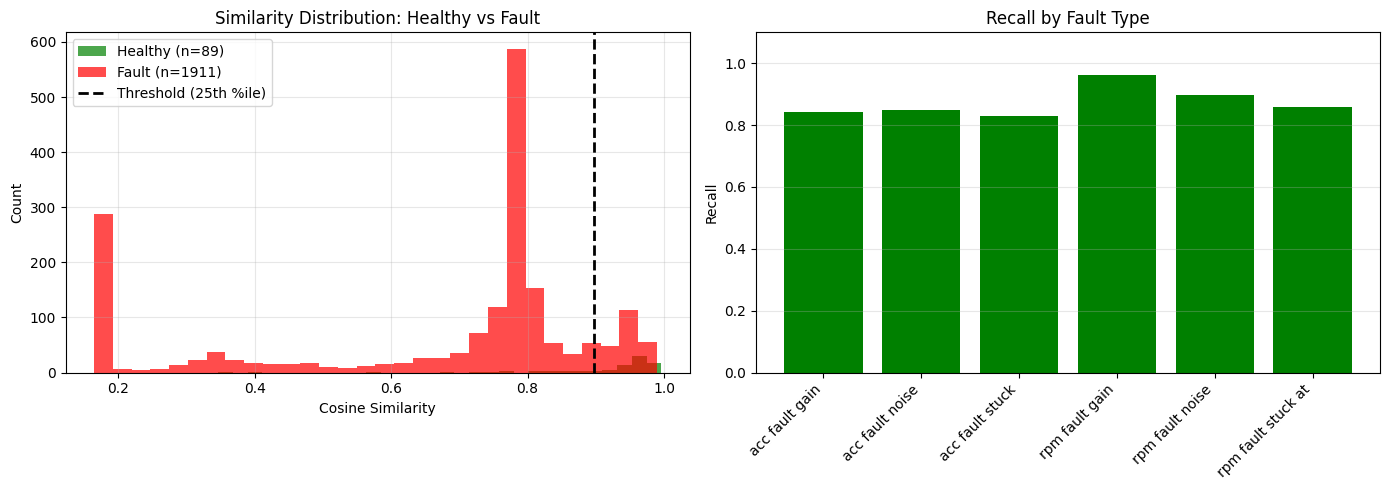

In [4]:
"""
Part 3: Anomaly Detection on HIL Data (CORRECTED)

Key Fixes:
1. Use FIRST 90 SECONDS of HIL DATASETS (as per supervisor email)
2. Use 25th percentile threshold
3. Better statistics reporting

Author: Claude (corrected version)
Date: 2026-01-05
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from scipy import stats
import os
import matplotlib.pyplot as plt

# ============================================================================
# CONFIGURATION
# ============================================================================

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HIL_PATH = r"D:\LapTop\Downloads\abbosh\Project\HIL"
SENSOR_NAMES = ['accelerator', 'speed']

WINDOW_SIZE = 200   # 2 seconds at 100 Hz
STRIDE = 100        # 50% overlap

# Use first 90 seconds only (as per supervisor email)
HIL_HEALTHY_DURATION_SECONDS = 90
HIL_SAMPLING_RATE = 100  

# Use 25th percentile
THRESHOLD_PERCENTILE = 25

print("=" * 80)
print("Part 3: Anomaly Detection on HIL Data (CORRECTED)")
print("=" * 80)
print(f"Device: {DEVICE}")
print(f"HIL Path: {HIL_PATH}")
print(f"Window size: {WINDOW_SIZE}")
print(f"Stride: {STRIDE}")
print(f"HIL Healthy Duration: {HIL_HEALTHY_DURATION_SECONDS} seconds")
print(f"Threshold: {THRESHOLD_PERCENTILE}th percentile")
print("=" * 80)
print()

# ============================================================================
# MODEL (Same as Part 2)
# ============================================================================

class Encoder(nn.Module):
    def __init__(self, input_channels=2, embedding_dim=256):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv1d(128, embedding_dim, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(embedding_dim)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.relu = nn.ReLU()
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)
        
        x = self.global_pool(x)
        x = x.squeeze(-1)
        return x

# ============================================================================
# LOAD ENCODER
# ============================================================================

print("[1/8] Loading trained encoder...")

checkpoint = torch.load("simclr_encoder_final.pth", map_location=DEVICE, weights_only=False)
encoder = Encoder(input_channels=2, embedding_dim=256).to(DEVICE)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
encoder.eval()
scaler = checkpoint['scaler']

print("✓ Encoder loaded")
print()

# ============================================================================
# HIL CSV PARSER
# ============================================================================

def parse_hil_csv(filepath):
    """Parse HIL CSV with non-standard format."""
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    
    # Find column names
    cols = None
    for line in lines[:50]:
        if line.startswith('path,'):
            cols = line.strip().split(',')[1:]
            break
    
    if cols is None:
        return None
    
    # Find data start
    data_start = None
    for i, line in enumerate(lines):
        if line.startswith('trace_values,'):
            data_start = i
            break
    
    if data_start is None:
        return None
    
    # Parse data
    rows = []
    for line in lines[data_start:]:
        parts = line.strip().split(',')[1:]
        if len(parts) == len(cols):
            rows.append(parts)
    
    df = pd.DataFrame(rows, columns=cols)
    df = df.apply(pd.to_numeric, errors='coerce')
    
    return df


def extract_sensors(df, filename):
    """Extract accelerator and speed from HIL data."""
    # Find speed column
    speed_col = None
    for col in df.columns:
        if 'v_Vehicle' in col or 'vehicle_speed' in col or 'speed' in col.lower():
            speed_col = col
            break
    
    if speed_col is None:
        print(f"  ✗ Speed column not found in {filename}")
        return None
    
    # Find accelerator column
    accel_col = None
    for col in df.columns:
        if 'AccPedal' in col or 'accelerator' in col.lower():
            accel_col = col
            break
    
    if accel_col is None:
        print(f"  ✗ Accelerator column not found in {filename}")
        return None
    
    # Extract data
    accelerator = df[accel_col].values
    speed = df[speed_col].values
    
    # Check for NaNs - use forward/backward fill instead of zero-filling
    if np.any(np.isnan(accelerator)) or np.any(np.isnan(speed)):
        print(f"  ⚠ NaNs found - will interpolate with forward/backward fill")
        
        accelerator = pd.Series(accelerator).interpolate(method='linear').ffill().bfill().values
        speed = pd.Series(speed).interpolate(method='linear').ffill().bfill().values
    
    return pd.DataFrame({
        'accelerator': accelerator,
        'speed': speed
    })

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def create_windows(data, window_size, stride):
    """Create sliding windows."""
    windows = []
    for start in range(0, len(data) - window_size + 1, stride):
        window = data[start:start + window_size, :]
        windows.append(window)
    return np.array(windows)


def extract_embeddings(windows):
    """Extract embeddings."""
    embeddings = []
    with torch.no_grad():
        for window in windows:
            window_tensor = torch.FloatTensor(window).transpose(0, 1).unsqueeze(0).to(DEVICE)
            embedding = encoder(window_tensor)
            embeddings.append(embedding.cpu().numpy().flatten())
    return np.array(embeddings)


def cosine_similarity(a, b):
    """Cosine similarity."""
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

# ============================================================================
# LOAD HIL HEALTHY DATA (FIRST 90 SECONDS ONLY!)
# ============================================================================

print("[2/8] Loading HIL healthy data (FIRST 90 SECONDS ONLY)...")

healthy_path = os.path.join(HIL_PATH, "healthy.csv")

if not os.path.exists(healthy_path):
    print(f"ERROR: {healthy_path} not found!")
    exit(1)

healthy_df_raw = parse_hil_csv(healthy_path)

if healthy_df_raw is None:
    print("ERROR: Failed to parse healthy.csv")
    exit(1)

healthy_df_full = extract_sensors(healthy_df_raw, "healthy.csv")

if healthy_df_full is None:
    print("ERROR: Failed to extract sensors from healthy.csv")
    exit(1)

# CRITICAL FIX: Use FIRST 90 SECONDS ONLY
cutoff_samples = HIL_HEALTHY_DURATION_SECONDS * HIL_SAMPLING_RATE
healthy_df = healthy_df_full.iloc[:cutoff_samples].copy()

print(f"Full healthy data: {len(healthy_df_full)} samples")
print(f"Using first {HIL_HEALTHY_DURATION_SECONDS} seconds: {len(healthy_df)} samples")
print()

# ============================================================================
# STATISTICS COMPARISON
# ============================================================================

print("[3/8] Comparing A2D2 vs HIL distributions...")
print()

print("="*80)
print("DISTRIBUTION COMPARISON: A2D2 (Train) vs HIL (Test)")
print("="*80)
print()

# A2D2 stats (from scaler)
print("A2D2 Training Statistics (from scaler):")
print(f"  Accelerator: μ={scaler.mean_[0]:.4f}, σ={scaler.scale_[0]:.4f}")
print(f"  Speed:       μ={scaler.mean_[1]:.4f}, σ={scaler.scale_[1]:.4f}")
print()

# HIL stats (before normalization)
print("HIL Healthy Statistics (first 90 seconds, BEFORE normalization):")
print(f"  Accelerator: μ={healthy_df['accelerator'].mean():.4f}, σ={healthy_df['accelerator'].std():.4f}")
print(f"  Speed:       μ={healthy_df['speed'].mean():.4f}, σ={healthy_df['speed'].std():.4f}")
print()

# Check for distribution mismatch
acc_diff = abs(healthy_df['accelerator'].mean() - scaler.mean_[0]) / scaler.scale_[0]
speed_diff = abs(healthy_df['speed'].mean() - scaler.mean_[1]) / scaler.scale_[1]

if acc_diff > 2 or speed_diff > 2:
    print("⚠️  WARNING: Significant distribution mismatch detected!")
    print(f"   Accelerator shift: {acc_diff:.2f}σ")
    print(f"   Speed shift: {speed_diff:.2f}σ")
else:
    print("✓ Distribution shift within acceptable range")
print()

# ============================================================================
# NORMALIZE AND CREATE WINDOWS
# ============================================================================

print("[4/8] Creating windows from healthy data...")

healthy_data = healthy_df[SENSOR_NAMES].values
healthy_normalized = scaler.transform(healthy_data)
healthy_windows = create_windows(healthy_normalized, WINDOW_SIZE, STRIDE)

print(f"Healthy windows: {len(healthy_windows)}")
print(f"Expected: ~{(len(healthy_df) - WINDOW_SIZE) // STRIDE + 1}")
print()

# ============================================================================
# EXTRACT EMBEDDINGS
# ============================================================================

print("[5/8] Extracting healthy embeddings...")

healthy_embeddings = extract_embeddings(healthy_windows)
healthy_mean = np.mean(healthy_embeddings, axis=0)

print(f"Embeddings shape: {healthy_embeddings.shape}")
print()

# ============================================================================
# SET THRESHOLD (25th PERCENTILE)
# ============================================================================

print("[6/8] Setting threshold (25th percentile)...")

healthy_sims = [cosine_similarity(e, healthy_mean) for e in healthy_embeddings]

threshold = np.percentile(healthy_sims, THRESHOLD_PERCENTILE)

print(f"Healthy similarity statistics:")
print(f"  Min:    {min(healthy_sims):.4f}")
print(f"  25th:   {np.percentile(healthy_sims, 25):.4f} ← THRESHOLD")
print(f"  Median: {np.median(healthy_sims):.4f}")
print(f"  90th:   {np.percentile(healthy_sims, 75):.4f}")
print(f"  Max:    {max(healthy_sims):.4f}")
print()
print(f"Threshold set to: {threshold:.4f}")
print()

# ============================================================================
# LOAD HIL FAULT DATA
# ============================================================================

print("[7/8] Loading HIL fault data...")
print()

fault_files = [
    "acc fault gain.csv",
    "acc fault noise.csv",
    "acc fault stuck.csv",
    "rpm fault gain.csv",
    "rpm fault noise.csv",
    "rpm fault stuck at.csv"
]

all_results = []
all_similarities = []
all_labels = []

# Add healthy to ROC (label = 0 = healthy)
all_similarities.extend(healthy_sims)
all_labels.extend([0] * len(healthy_sims))

print("="*80)
print("HIL FAULT DETECTION RESULTS")
print("="*80)
print()

for fault_file in fault_files:
    fault_path = os.path.join(HIL_PATH, fault_file)
    
    if not os.path.exists(fault_path):
        print(f"[{fault_file}] ✗ File not found, skipping")
        continue
    
    print(f"[{fault_file}]")
    
    # Parse CSV
    fault_df_raw = parse_hil_csv(fault_path)
    
    if fault_df_raw is None:
        print(f"  ✗ Failed to parse")
        continue
    
    # Extract sensors
    fault_df = extract_sensors(fault_df_raw, fault_file)
    
    if fault_df is None:
        continue
    
    # fault_df = fault_df.iloc[:cutoff_samples].copy()  # First 90 seconds only

    print(f"  Samples: {len(fault_df)}")
    
    # Normalize
    fault_data = fault_df[SENSOR_NAMES].values
    fault_normalized = scaler.transform(pd.DataFrame(fault_data, columns=SENSOR_NAMES))
    
    # Windows
    fault_windows = create_windows(fault_normalized, WINDOW_SIZE, STRIDE)
    
    if len(fault_windows) == 0:
        print(f"  ✗ No windows created")
        continue
    
    print(f"  Windows: {len(fault_windows)}")
    
    # Embeddings
    fault_embeddings = extract_embeddings(fault_windows)
    
    # Similarities
    similarities = [cosine_similarity(e, healthy_mean) for e in fault_embeddings]
    
    # Predictions (similarity < threshold → anomaly)
    predictions = (np.array(similarities) < threshold).astype(int)
    y_true = np.ones(len(predictions))  # All are faults
    
    # Metrics
    detected = predictions.sum()
    precision = precision_score(y_true, predictions, zero_division=0)
    recall = recall_score(y_true, predictions, zero_division=0)
    f1 = f1_score(y_true, predictions, zero_division=0)
    
    # Add to overall (label = 1 = fault)
    all_similarities.extend(similarities)
    all_labels.extend([1] * len(similarities))
    
    print(f"  Detected: {detected}/{len(predictions)} ({detected/len(predictions)*100:.1f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Sim range: [{min(similarities):.4f}, {max(similarities):.4f}]")
    print()
    
    all_results.append({
        'fault': fault_file,
        'windows': len(predictions),
        'detected': detected,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'sim_min': min(similarities),
        'sim_max': max(similarities)
    })

# ============================================================================
# OVERALL METRICS
# ============================================================================

print("[8/8] Computing overall metrics...")
print()

if len(all_results) == 0:
    print("ERROR: No fault files were processed!")
    exit(1)

# ROC-AUC (lower similarity = more anomalous, so negate)
try:
    roc_auc = roc_auc_score(all_labels, [-s for s in all_similarities])
except Exception as e:
    print(f"ROC-AUC Error: {e}")
    roc_auc = 0.0

# ============================================================================
# SUMMARY
# ============================================================================

print("="*80)
print("SUMMARY TABLE - PER FAULT TYPE")
print("="*80)
print()

print(f"{'Fault File':<25} {'Windows':>8} {'Detected':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
print("-" * 73)

for r in all_results:
    detected_str = f"{r['detected']}/{r['windows']}"
    print(f"{r['fault']:<25} {r['windows']:>8} {detected_str:>10} {r['precision']:>10.4f} {r['recall']:>10.4f} {r['f1']:>10.4f}")

print("-" * 73)

avg_precision = np.mean([r['precision'] for r in all_results])
avg_recall = np.mean([r['recall'] for r in all_results])
avg_f1 = np.mean([r['f1'] for r in all_results])
total_windows = sum([r['windows'] for r in all_results])
total_detected = sum([r['detected'] for r in all_results])

print(f"{'TOTAL/AVERAGE':<25} {total_windows:>8} {f'{total_detected}/{total_windows}':>10} {avg_precision:>10.4f} {avg_recall:>10.4f} {avg_f1:>10.4f}")

print()
print("="*80)
print("OVERALL METRICS")
print("="*80)
print()
print(f"Total Fault Windows:   {total_windows}")
print(f"Total Detected:        {total_detected} ({total_detected/total_windows*100:.1f}%)")
print()
print(f"Average Precision:     {avg_precision:.4f}")
print(f"Average Recall:        {avg_recall:.4f}")
print(f"Average F1-Score:      {avg_f1:.4f}")
print(f"ROC-AUC:               {roc_auc:.4f}")
print()

# ============================================================================
# SAVE RESULTS
# ============================================================================

results_df = pd.DataFrame(all_results)
results_df.to_csv('hil_detection_results.csv', index=False)
print("\n✓ Results saved to: hil_detection_results.csv")

# ============================================================================
# DIAGNOSTIC PLOT
# ============================================================================

print("\nCreating diagnostic plot...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Similarity distribution
ax1 = axes[0]
healthy_sims_arr = np.array([s for s, l in zip(all_similarities, all_labels) if l == 0])
fault_sims_arr = np.array([s for s, l in zip(all_similarities, all_labels) if l == 1])

ax1.hist(healthy_sims_arr, bins=30, alpha=0.7, label=f'Healthy (n={len(healthy_sims_arr)})', color='green')
ax1.hist(fault_sims_arr, bins=30, alpha=0.7, label=f'Fault (n={len(fault_sims_arr)})', color='red')
ax1.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD_PERCENTILE}th %ile)')
ax1.set_xlabel('Cosine Similarity')
ax1.set_ylabel('Count')
ax1.set_title('Similarity Distribution: Healthy vs Fault')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Per-fault recall
ax2 = axes[1]
fault_names = [r['fault'].replace('.csv', '') for r in all_results]
recalls = [r['recall'] for r in all_results]
colors = ['green' if r >= 0.7 else 'orange' if r >= 0.5 else 'red' for r in recalls]

bars = ax2.bar(range(len(fault_names)), recalls, color=colors)
# ax2.axhline(0.712, color='blue', linestyle='--', label='Thesis target (71.2%)')
ax2.set_xticks(range(len(fault_names)))
ax2.set_xticklabels(fault_names, rotation=45, ha='right')
ax2.set_ylabel('Recall')
ax2.set_title('Recall by Fault Type')
ax2.set_ylim(0, 1.1)
#ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('hil_detection_diagnostic.png', dpi=150, bbox_inches='tight')
print("✓ Diagnostic plot saved to: hil_detection_diagnostic.png")